In [8]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

In [3]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()
# Load MNIST data set
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)


9920512it [00:04, 2053640.66it/s]                             


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw


32768it [00:01, 18195.76it/s]                           


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw


1654784it [00:02, 613894.54it/s]                             


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw


8192it [00:00, 17150.04it/s]            


Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw
Processing...
Done!


In [5]:
# Create training and test dataloaders

num_workers = 0
batch_size = 20

# Data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

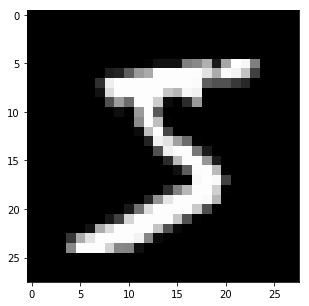

In [7]:
# Explore the data
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# Get one image
img = np.squeeze(images[0])

# Plot image
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [19]:
# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x
    
        

In [20]:
# Build the Net
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [21]:
# Loss and optimizers
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:

# number of epochs to train the model
n_epochs = 30

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = loss_function(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    

Epoch: 1 	Training Loss: 0.501087
Epoch: 2 	Training Loss: 0.266010
Epoch: 3 	Training Loss: 0.232676
Epoch: 4 	Training Loss: 0.216200
Epoch: 5 	Training Loss: 0.207429
Epoch: 6 	Training Loss: 0.201062
Epoch: 7 	Training Loss: 0.195127
Epoch: 8 	Training Loss: 0.190489
Epoch: 9 	Training Loss: 0.186961
Epoch: 10 	Training Loss: 0.183081
Epoch: 11 	Training Loss: 0.180147
Epoch: 12 	Training Loss: 0.177550
Epoch: 13 	Training Loss: 0.175492
Epoch: 14 	Training Loss: 0.173690
Epoch: 15 	Training Loss: 0.172139
Epoch: 16 	Training Loss: 0.170694
Epoch: 17 	Training Loss: 0.169582
Epoch: 18 	Training Loss: 0.168662
Epoch: 19 	Training Loss: 0.167831
Epoch: 20 	Training Loss: 0.167142
Epoch: 21 	Training Loss: 0.166574
Epoch: 22 	Training Loss: 0.166090
Epoch: 23 	Training Loss: 0.165636
Epoch: 24 	Training Loss: 0.165185
Epoch: 25 	Training Loss: 0.164745
Epoch: 26 	Training Loss: 0.164317
Epoch: 27 	Training Loss: 0.163867
Epoch: 28 	Training Loss: 0.163324
Epoch: 29 	Training Loss: 0.1

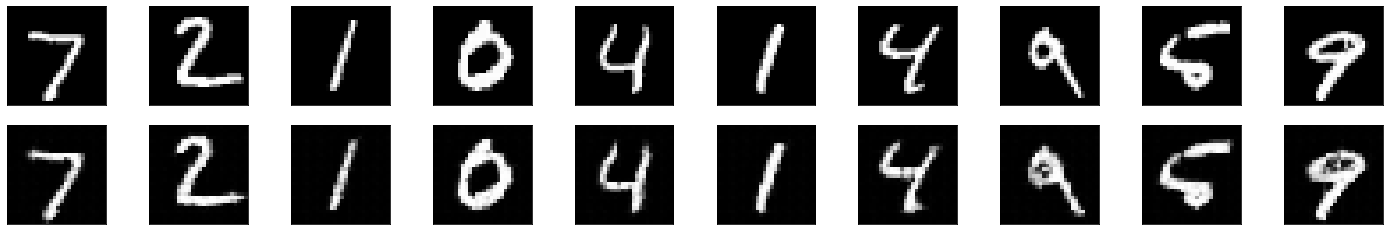

In [23]:
# Check results
dataiter = iter(test_loader)
images, labels = dataiter.next()

# Get sample outputs
output = model(images)
# Prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 28,28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)